In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [118]:
# open the data file
with h5py.File('../CodePass2/runs/stas_comments_10.hdf5', 'r') as f:
    # read the data
    x = f['x'][:]
 

print(x.shape)




# find voronoi diagram
from scipy.spatial import Delaunay


def get_nbs(xs):
    tri = Delaunay(xs)
    indsx, all_neighbors = tri.vertex_neighbor_vertices

    neighbors = []
    for i in range(len(indsx)-1):
        neighbors.append(set(all_neighbors[indsx[i]:indsx[i+1]]))

    return neighbors


(1001, 5000, 3)


In [143]:


countss = []

for iii in range(0,10):
    print(iii)
    counts = []

    nbs_0 = get_nbs(x[iii*25])
    nbs_1 = get_nbs(x[(iii+1)*25])

    pairs = []

    for i in range(len(nbs_0)):
        new_nbs = nbs_1[i] - nbs_0[i]

        for new_nb in new_nbs:
            if set([i, new_nb]) in pairs:
                continue
            pairs.append(set([i, new_nb]))
            nb_nbs = nbs_1[new_nb]
            overlap = nb_nbs & nbs_1[i]
            
            tobreak = False
            count = 0
            for common_nb in overlap:
                common_ns_prev_nbs = nbs_0[common_nb]
                common_nb_new_nbs = nbs_1[common_nb]

                overlapx2 = (common_ns_prev_nbs - common_nb_new_nbs) & overlap 

                if len(overlapx2) > 0:
                    count += 0.5
                    tobreak = True

            counts.append(count)
            if tobreak:
                break

    countss.append(counts)





0
1
2
3
4
5
6
7
8
9


In [144]:
countss

[[0,
  2.5,
  0,
  0,
  0,
  2.5,
  0,
  1.0,
  2.0,
  2.0,
  0,
  1.0,
  0,
  1.0,
  1.0,
  2.5,
  1.0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2.0,
  0,
  1.5,
  1.0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.5,
  0,
  0,
  0,
  1.0,
  1.0,
  0,
  2.0,
  1.0,
  1.0,
  2.0,
  0,
  1.5,
  0,
  0,
  1.5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  1.5,
  0,
  0,
  0,
  0,
  1.5,
  0,
  0,
  1.0,
  0,
  2.0,
  2.0,
  0,
  1.0,
  0,
  1.0,
  0,
  1.5,
  0,
  0,
  1.0,
  0,
  0,
  1.0,
  0,
  1.5,
  0,
  0,
  1.0,
  0,
  1.5,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  1.5,
  0,
  0,
  2.0,
  0,
  1.0,
  1.0,
  0,
  1.0,
  0,
  1.0,
  0,
  0,
  2.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.5,
  0,
  0,
  0,
  0,
  0,
  1.0,
  1.5,
  0,
  2.5,
  1.0,
  2.0,
  0,
  1.5,
  2.0,
  0,
  3.0,
  1.0,
  0,
  1.0,
  0,
  2.0,
  1.0,
  1.0,
  0,
  1.5,
  1.5,
  1.5,
  1.0,
  0,
  2.0,
  2.0,
  0,
  0,
  1.0,
  1.0,
  0,
  0,
  2.0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,


In [145]:
count_dict = {}
for cc in countss:
    unique, counts = np.unique(cc, return_counts=True)
    for u, c in zip(unique, counts):
        if u not in count_dict:
            count_dict[u] = [c]
        else:
            count_dict[u] += [c]


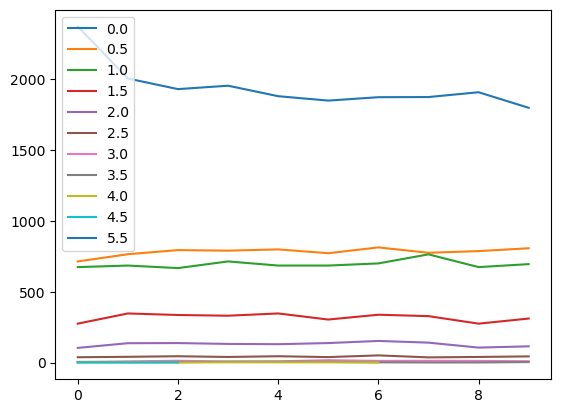

In [148]:
for key in count_dict:
    if key == 0:
        continue
    plt.plot(count_dict[key], label=key-1)

plt.legend()
plt.show()